In [2]:
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
import os, s3fs
import xarray as xr
import geopandas as gpd
import sqlalchemy as sa

from datetime import datetime

## Helper Functions for Flowline Retrieval

These are two ways to get flowlines, either from the NHD web service using HyRiver's `pynhd` package, or from our database where we've ingested the same data. The NHD web service is more portable but slower.

In [3]:
def get_flowlines_from_db(huc):
    con = sa.create_engine(
        "{driver}://{user}:{password}@{host}/{database}".format(
            driver="postgresql+psycopg2",
            user=os.getenv("PGUSER"),
            password=os.getenv("PGPASSWORD"),
            host=os.getenv("PGHOST"),
            database="nhdplusv2",
        )
    )

    sql = f"""
        SELECT comid, shape
        FROM nhdflowline_network
        WHERE ST_Intersects(
            shape,
            ST_Transform(
                ST_SetSRID(
                    ST_GeomFromText('{huc.geometry[0].wkt}'),
                    4326),
                4269)
        )
    """
    
    return gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

In [4]:
def get_flowlines_from_web(huc):
    return NHD('flowline_mr').bygeom(huc.geometry[0].geoms[0])

CPU times: user 601 ms, sys: 40.2 ms, total: 642 ms
Wall time: 921 ms


<AxesSubplot:>

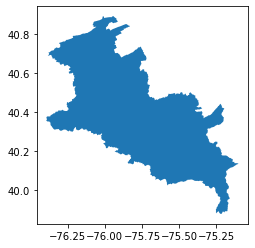

In [5]:
%%time

huc = WaterData('wbd08_20201006').byid('huc8', '02040203')
huc.geometry.plot()

Get flowlines contained within that shape

CPU times: user 373 ms, sys: 117 ms, total: 490 ms
Wall time: 989 ms


<AxesSubplot:>

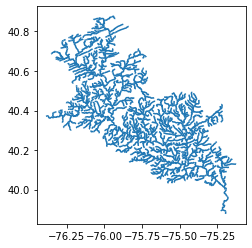

In [6]:
%%time

flowlines = get_flowlines_from_db(huc)
flowlines.plot()

Get the most recent NWM Short Term Forecast day

In [7]:
%%time

fs = s3fs.S3FileSystem(anon=True)
today = datetime.now().strftime('%Y%m%d')

netcdf_url = f's3://noaa-nwm-pds/nwm.{today}/short_range/nwm.t00z.short_range.channel_rt.*.conus.nc'
fileset = [fs.open(file) for file in fs.glob(netcdf_url)]

ds = xr.open_mfdataset(fileset, engine='h5netcdf',
                       data_vars=['streamflow'], coords='minimal', compat='override')

CPU times: user 2.42 s, sys: 269 ms, total: 2.69 s
Wall time: 5.28 s


Subset the dataset to only the streams within the HUC. Also, pick the first forecast for the day.

In [8]:
%%time

nhd_reaches = set([int(f) for f in flowlines['comid']])
nwm_reaches = set(ds.feature_id.values)

common_reaches = list(set(nwm_reaches).intersection(set(nhd_reaches)))

sub_ds = ds.sel(feature_id=common_reaches)
df = sub_ds['streamflow'].to_dataframe().swaplevel()

CPU times: user 1.68 s, sys: 341 ms, total: 2.02 s
Wall time: 1.6 s


Pick the top streams that have the highest streamflow predictions, choosing all above a certain percentile.

In [9]:
cutoff_percentile = 50.0
high_streamflow_cutoff = df.groupby('feature_id').mean('streamflow').quantile(cutoff_percentile / 100)[0]
sub_df = df[df.streamflow > high_streamflow_cutoff]

Join the NWM streamflow forecast with the NHD flowlines, and visualize it

In [10]:
%%time
joined = flowlines.merge(sub_df, left_on='comid', right_on='feature_id')

CPU times: user 6.24 ms, sys: 0 ns, total: 6.24 ms
Wall time: 5.22 ms


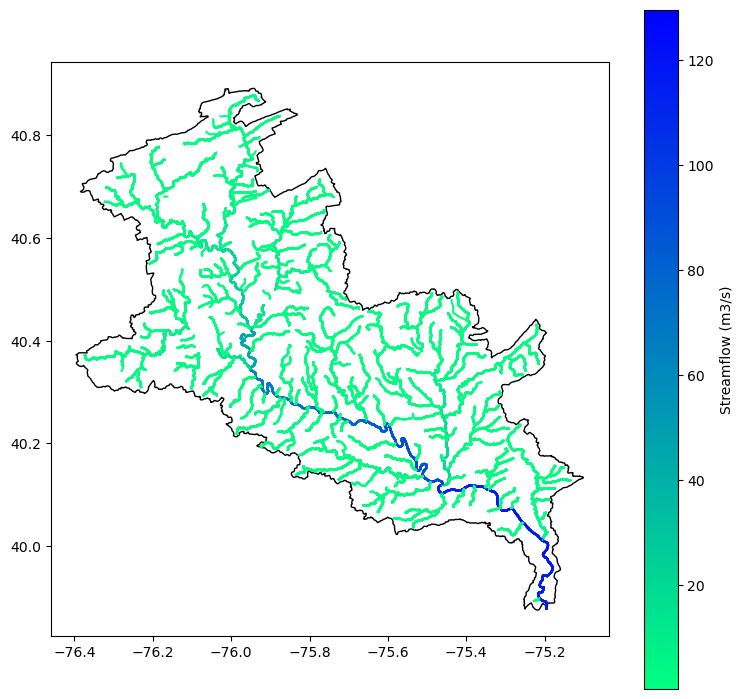

In [11]:
ax = huc.plot(facecolor="none", edgecolor="k", figsize=(9, 9))
joined.plot(ax=ax, column="streamflow", cmap='winter_r', legend=True, legend_kwds={"label": "Streamflow (m3/s)"})
ax.figure.set_dpi(100)

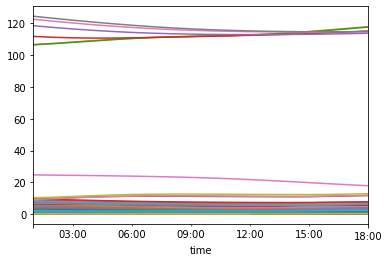

In [12]:
comids = sub_df.index.get_level_values(0)
ax = sub_df.loc[comids[0]].plot(legend=False)
for comid in comids[1:100]:
    sub_df.loc[comid].plot(ax=ax, legend=False)